# Version 1 - Base model

## 1. Imports

In [ ]:
import os

import numpy as np
import cv2

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from PIL import Image
from IPython.display import display

import torch
import torch.nn as nn

from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.optim.lr_scheduler import StepLR
from torchsummary import summary
from tqdm import tqdm

## 2. Setup data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
## set the path to train and test set
## data_path = <path>
## drive location
## for colab set the folders in colab root folder
#<zip file location>
## !unzip '<path>' 
data_path = '/content/chest_xray'

## 3. Explore data

In [7]:
class_name = ['NORMAL','PNEUMONIA']
def get_list_files(dirName):
    '''
    input - directory location
    output - list the files in the directory
    '''
    files_list = os.listdir(dirName)
    return files_list

files_list_normal_train = get_list_files(data_path+'/train/'+class_name[0])
files_list_pneu_train = get_list_files(data_path+'/train/'+class_name[1])

files_list_normal_test = get_list_files(data_path+'/test/'+class_name[0])
files_list_pneu_test = get_list_files(data_path+'/test/'+class_name[1])

In [8]:
print("Number of train samples in Normal category {}".format(len(files_list_normal_train)))
print("Number of train samples in Pneumonia category {}".format(len(files_list_pneu_train)))

print("Number of test samples in Normal category {}".format(len(files_list_normal_test)))
print("Number of test samples in Pneumonia category {}".format(len(files_list_pneu_test)))

Number of train samples in Normal category 1349
Number of train samples in Pneumonia category 3883
Number of test samples in Normal category 234
Number of test samples in Pneumonia category 390


(1104, 1240)


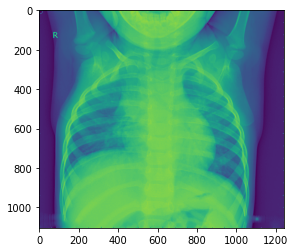

In [9]:
## get random file to check
img = data_path + '/train/NORMAL/'+ files_list_normal_train[np.random.randint(0,len(files_list_normal_train))]
print(plt.imread(img).shape)
#display(Image.open(img,'r'),)

img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

(1216, 1344)


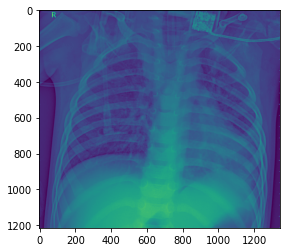

In [10]:
## get random file to check pneumona 
img = data_path + '/train/PNEUMONIA/'+ files_list_pneu_train[np.random.randint(0,len(files_list_pneu_train))]
print(plt.imread(img).shape)
#display(Image.open(img,'r'),)

img = mpimg.imread(img)
imgplot = plt.imshow(img)
plt.show()

In [11]:
train_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])

test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                          [0.229, 0.224, 0.225])
])

In [12]:
## getting train and test data loader in place
train_data = datasets.ImageFolder(os.path.join(data_path, 'train'), transform= train_transform)
test_data = datasets.ImageFolder(os.path.join(data_path, 'test'), transform= test_transform)

train_loader = DataLoader(train_data,
                          batch_size= 16, shuffle= True, pin_memory= True)
test_loader = DataLoader(test_data, 
                         batch_size= 1, shuffle= False, pin_memory= True)

class_names = train_data.classes

print(class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of test images: {len(test_data)}')


['NORMAL', 'PNEUMONIA']
Number of train images: 5232
Number of test images: 624


## 4. Define Model

In [13]:

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), 
                      padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(4)
        ) 
        self.pool11 = nn.MaxPool2d(2, 2)

        # CONVOLUTION BLOCK 
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3),
                      padding=0, bias=False),
            nn.ReLU(),
            #nn.BatchNorm2d(16)
        ) 

        # TRANSITION BLOCK 

        self.pool22 = nn.MaxPool2d(2, 2) 

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(10),
            nn.ReLU()
        ) 
        self.pool33 = nn.MaxPool2d(2, 2) 
        

        # CONVOLUTION BLOCK 
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(10)
        )

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(32),
            nn.ReLU(),
           
        ) 

        
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(10),
            
        )

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(10)
         
        )

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
            
            nn.ReLU(),
            #nn.BatchNorm2d(32)
        )

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(10),
            
        ) 

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=14, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(14),
            
        ) 

        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=14, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),            
            #nn.BatchNorm2d(16),
            
        ) 
        
        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) 

        self.convblockout = nn.Sequential(
              nn.Conv2d(in_channels=16, out_channels=2, kernel_size=(4, 4), padding=0, bias=False),

        ) 



    def forward(self, x):
        x = self.convblock1(x)
        x = self.pool11(x)
        x = self.convblock2(x)
        x = self.pool22(x)
        x = self.convblock3(x)
        x = self.pool33(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.convblock10(x)
        x = self.convblock11(x)
        x = self.gap(x)        
        x = self.convblockout(x)

        x = x.view(-1, 2)
        return F.log_softmax(x, dim=-1)


In [14]:

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available processor {}".format(device))
model = Net().to(device)
summary(model, input_size=(3, 224, 224))

Available processor cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 222, 222]             216
              ReLU-2          [-1, 8, 222, 222]               0
         MaxPool2d-3          [-1, 8, 111, 111]               0
            Conv2d-4         [-1, 16, 109, 109]           1,152
              ReLU-5         [-1, 16, 109, 109]               0
         MaxPool2d-6           [-1, 16, 54, 54]               0
            Conv2d-7           [-1, 10, 54, 54]             160
              ReLU-8           [-1, 10, 54, 54]               0
         MaxPool2d-9           [-1, 10, 27, 27]               0
           Conv2d-10           [-1, 10, 25, 25]             900
             ReLU-11           [-1, 10, 25, 25]               0
           Conv2d-12           [-1, 32, 25, 25]             320
             ReLU-13           [-1, 32, 25, 25]               0
           Con

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


## 5. Training process

In [15]:


train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # get data
        data, target = data.to(device), target.to(device)

        # Initialization of gradient
        optimizer.zero_grad()
        # In PyTorch, gradient is accumulated over backprop and even though thats used in RNN generally not used in CNN 
        # or specific requirements
        ## prediction on data
        y_pred = model(data)

        # Calculating loss given the prediction
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Backprop
        loss.backward()
        optimizer.step()
        # get the index of the log-probability corresponding to the max value
        pred = y_pred.argmax(dim=1, keepdim=True)  
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)

        pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
        train_accuracies.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item() 
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))

    test_accuracies.append(100. * correct / len(test_loader.dataset))


In [16]:


model =  Net().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH number :", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    print('Current Learing Rate : ', optimizer.state_dict()["param_groups"][0]["lr"])
    test(model, device, test_loader)

EPOCH: 0


Loss=0.6931475400924683 Batch_id=326 Accuracy=26.45: 100%|██████████| 327/327 [01:36<00:00,  3.39it/s]


current Learing Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 222/624 (35.58%)

EPOCH: 1


Loss=0.6931475400924683 Batch_id=326 Accuracy=27.05: 100%|██████████| 327/327 [01:36<00:00,  3.38it/s]


current Learing Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 222/624 (35.58%)

EPOCH: 2


Loss=0.6931474804878235 Batch_id=326 Accuracy=27.64: 100%|██████████| 327/327 [01:37<00:00,  3.35it/s]


current Learing Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 222/624 (35.58%)

EPOCH: 3


Loss=0.6931477189064026 Batch_id=326 Accuracy=28.31: 100%|██████████| 327/327 [01:37<00:00,  3.36it/s]


current Learing Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 221/624 (35.42%)

EPOCH: 4


Loss=0.6931475400924683 Batch_id=326 Accuracy=28.92: 100%|██████████| 327/327 [01:35<00:00,  3.43it/s]


current Learing Rate:  0.01

Test set: Average loss: 0.6931, Accuracy: 225/624 (36.06%)

EPOCH: 5


Loss=0.6931474208831787 Batch_id=326 Accuracy=29.47: 100%|██████████| 327/327 [01:37<00:00,  3.36it/s]


current Learing Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 229/624 (36.70%)

EPOCH: 6


Loss=0.6931476593017578 Batch_id=326 Accuracy=30.18: 100%|██████████| 327/327 [01:34<00:00,  3.46it/s]


current Learing Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 230/624 (36.86%)

EPOCH: 7


Loss=0.6931472420692444 Batch_id=326 Accuracy=30.54: 100%|██████████| 327/327 [01:35<00:00,  3.42it/s]


current Learing Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 233/624 (37.34%)

EPOCH: 8


Loss=0.6931474208831787 Batch_id=326 Accuracy=30.93: 100%|██████████| 327/327 [01:35<00:00,  3.42it/s]


current Learing Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 233/624 (37.34%)

EPOCH: 9


Loss=0.6931475400924683 Batch_id=326 Accuracy=31.08: 100%|██████████| 327/327 [01:34<00:00,  3.45it/s]


current Learing Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 235/624 (37.66%)

EPOCH: 10


Loss=0.6931473612785339 Batch_id=326 Accuracy=31.48: 100%|██████████| 327/327 [01:34<00:00,  3.47it/s]


current Learing Rate:  0.005

Test set: Average loss: 0.6931, Accuracy: 238/624 (38.14%)

EPOCH: 11


Loss=0.6931474804878235 Batch_id=326 Accuracy=31.92: 100%|██████████| 327/327 [01:35<00:00,  3.42it/s]


current Learing Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 238/624 (38.14%)

EPOCH: 12


Loss=0.6931474804878235 Batch_id=326 Accuracy=32.22: 100%|██████████| 327/327 [01:35<00:00,  3.43it/s]


current Learing Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 238/624 (38.14%)

EPOCH: 13


Loss=0.6931471824645996 Batch_id=326 Accuracy=32.28: 100%|██████████| 327/327 [01:34<00:00,  3.47it/s]


current Learing Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 238/624 (38.14%)

EPOCH: 14


Loss=0.6931472420692444 Batch_id=326 Accuracy=32.57: 100%|██████████| 327/327 [01:35<00:00,  3.43it/s]


current Learing Rate:  0.0025

Test set: Average loss: 0.6931, Accuracy: 237/624 (37.98%)



Text(0.5, 1.0, 'Test Accuracy')

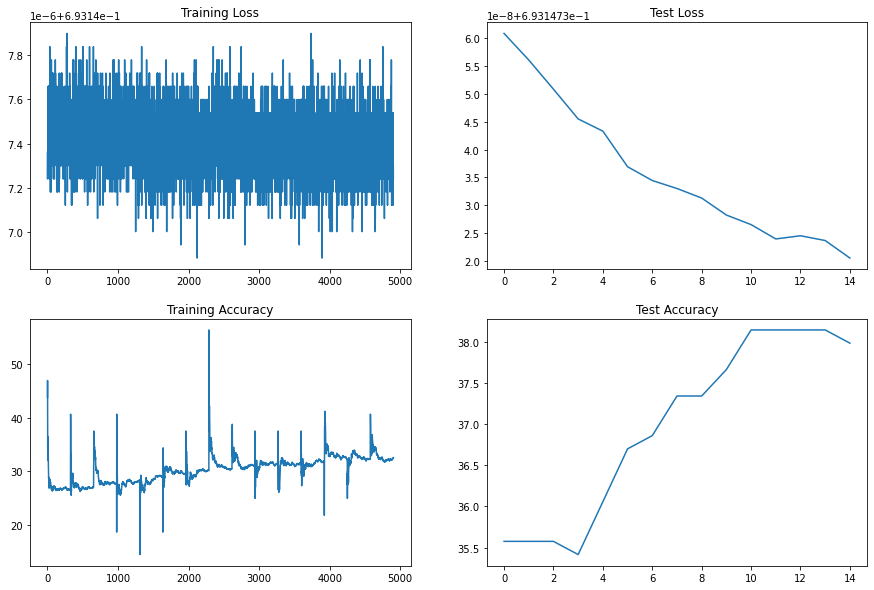

In [17]:

torch.cuda.synchronize()
train_losses1 = [float(i.cpu().detach().numpy()) for i in train_losses]
train_acc1 = [i for i in train_accuracies]
test_losses1 = [i for i in test_losses]
test_acc1 = [i for i in test_accuracies]

fig, axs = plt.subplots(2,2,figsize=(16,10))
axs[0, 0].plot(train_losses1,color='green')
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc1,color='green')
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses1)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc1)
axs[1, 1].set_title("Test Accuracy")